In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import pandas as pd
from torch import nn
from time import time
from os import path
from torchvision import transforms
import random
from copy import deepcopy

from torch.utils.data import Dataset, DataLoader, sampler
from os import path

In [ ]:
# BIDS.tsv
OASIS_df = pd.read_csv(
    '/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/OASIS_BIDS.tsv', sep='\t')

print(OASIS_df.head())

   participant_id session_id alternative_id_1 sex  education_level  age_bl  \
0  sub-OASIS10001    ses-M00    OAS1_0001_MR1   F              2.0      74   
1  sub-OASIS10002    ses-M00    OAS1_0002_MR1   F              4.0      55   
2  sub-OASIS10003    ses-M00    OAS1_0003_MR1   F              4.0      73   
3  sub-OASIS10004    ses-M00    OAS1_0004_MR1   M              NaN      28   
4  sub-OASIS10005    ses-M00    OAS1_0005_MR1   M              NaN      18   

   cdr diagnosis_bl laterality   MMS  cdr_global diagnosis  
0  0.0           CN          R  29.0         0.0        CN  
1  0.0           CN          R  29.0         0.0        CN  
2  0.5           AD          R  27.0         0.5        AD  
3  NaN           CN          R  30.0         NaN        CN  
4  NaN           CN          R  30.0         NaN        CN  


#### 스케일링하는 이유
거리 기반의 모델링(distance based model)을 수행할 때 상대적으로 범위가 넓은 몸무게 변수가 거리 계산을 하는 과정에서 더 많은 기여를 하게 되어 더 중요한 변수 or 영향력이 높은 변수로 인식될 수 있다. 
따라서, 이러한 문제를 방지하기위한 방법 중 하나로 범위를 재정의하는 스케일링을 수행한다.   


거리-기반 모델링을 수행할 때 표준화를 사용해야하는 이유이며, 각 적용하고자 하는 모델링 방법에 따라 이유는 다르지만, 보통 모델에 동일한 기여를 하게끔 만들어 주는 것이 목적이다.  

⇒ Q. **입력되는 데이터가 이미지 하나(=변수 하나?)인데 왜 이미지 텐서에 정규화를 하는지**  

같은 사진이라 하더라도 아이폰으로 찍은 사진, 갤럭시로 찍은 사진, 디지털카메라로 찍은 사진 등 서로 픽셀 값의 범위가 다를 수 있다.   
A : 강아지 / B : 코끼리를 찍었다고 했을 때,   
C의 픽셀 범위가 A와 비슷하다면 코끼리 이미지가 입력되더라도 강아지라 출력할 확률이 높기 때문에 스케일링을 통해 범위를 동일하게 만들어준다.

In [ ]:
class MinMaxNormalization(object):
    def __call__(self, image):
        return (image - image.min()) / (image.max() - image.min())

    def train(self):
        self.train_mode = True

    def eval(self):
        self.train_mode = False

In [ ]:
class MRIDataset(Dataset):

    def __init__(self, img_dir, data_df, transform=None):
        """
        Args:
            img_dir (str): path to the CAPS directory containing preprocessed images
            data_df (DataFrame): metadata of the population.
                Columns include participant_id, session_id and diagnosis).
            transform (callable): list of transforms applied on-the-fly, chained with torchvision.transforms.Compose.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.data_df = data_df
        self.label_code = {"AD": 1, "CN": 0}

        self.size = self[0]['image'].shape

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):

        diagnosis = self.data_df.loc[idx, 'diagnosis']
        label = self.label_code[diagnosis]

        participant_id = self.data_df.loc[idx, 'participant_id']
        session_id = self.data_df.loc[idx, 'session_id']
        filename = 'subjects/' + participant_id + '/' + session_id + '/' + \
          'deeplearning_prepare_data/image_based/custom/' + \
          participant_id + '_' + session_id + \
          '_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'

        image = torch.load(path.join(self.img_dir, filename))

        if self.transform:
            image = (image - image.min()) / (image.max() - image.min())

        sample = {'image': image, 'label': label,
                  'participant_id': participant_id,
                  'session_id': session_id}
        return sample

    def train(self):
        self.transform.train()

    def eval(self):
        self.transform.eval()

In [ ]:
class MRIDatasetRoi(MRIDataset):

    def __init__(self, img_dir, data_df, transform=MinMaxNormalization()):
        """
        Args:
            img_dir (str): path to the CAPS directory containing preprocessed images
            data_df (DataFrame): metadata of the population.
                Columns include participant_id, session_id and diagnosis).
            transform (callable): list of transforms applied on-the-fly, chained with torchvision.transforms.Compose.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.data_df = data_df
        self.label_code = {"AD": 1, "CN": 0}

        self.size = self[0]['image'].shape

    def __call__(self, img):
      """
      if left_is_odd == 1: # the center of the left hippocampus
        crop_center = (61, 96, 68)
      else: # the center of the right hippocampus
        crop_center = (109, 96, 68)
      """
      crop_size = (50, 50, 50) # patch를 50*50*50 크기로 잘라줌
      crop_center = (61, 96, 68) # the center of the left hippocampus

      extracted_roi = img[
        :,
        crop_center[0] - crop_size[0] // 2: crop_center[0] + crop_size[0] // 2:,
        crop_center[1] - crop_size[1] // 2: crop_center[1] + crop_size[1] // 2:,
        crop_center[2] - crop_size[2] // 2: crop_center[2] + crop_size[2] // 2:
        ].clone()

      return extracted_roi

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):

        diagnosis = self.data_df.loc[idx, 'diagnosis']
        label = self.label_code[diagnosis]

        participant_id = self.data_df.loc[idx, 'participant_id']
        session_id = self.data_df.loc[idx, 'session_id']
        filename = 'subjects/' + participant_id + '/' + session_id + '/' + \
          'deeplearning_prepare_data/image_based/custom/' + \
          participant_id + '_' + session_id + \
          '_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'

        image = torch.load(path.join(self.img_dir, filename))

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'label': label,
                  'participant_id': participant_id,
                  'session_id': session_id}
        return sample

    def train(self):
        self.transform.train()

    def eval(self):
        self.transform.eval()

In [ ]:
class ROI(object):
  def __init__(self, random_shift=0):
        self.random_shift = random_shift
        self.train_mode = True
  def __call__(self, img):
    crop_size = (50, 50, 50)
    crop_center = (61, 96, 68)

    extracted_roi = img[
      :,
      crop_center[0] - crop_size[0] // 2: crop_center[0] + crop_size[0] // 2:,
      crop_center[1] - crop_size[1] // 2: crop_center[1] + crop_size[1] // 2:,
      crop_center[2] - crop_size[2] // 2: crop_center[2] + crop_size[2] // 2:
      ].clone()

    return extracted_roi

  def train(self):
        self.train_mode = True

  def eval(self):
        self.train_mode = False

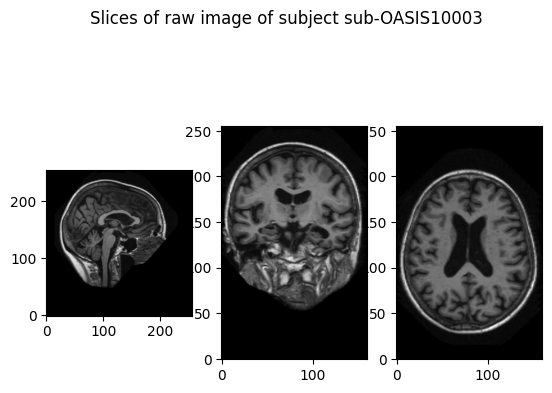

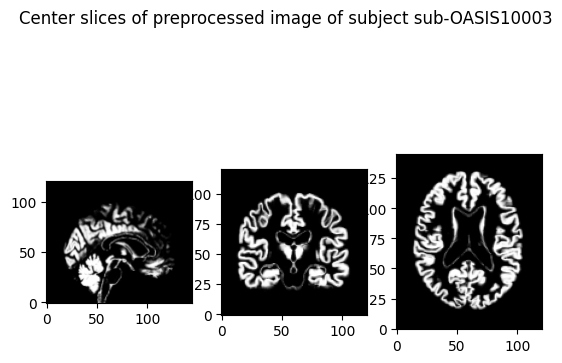

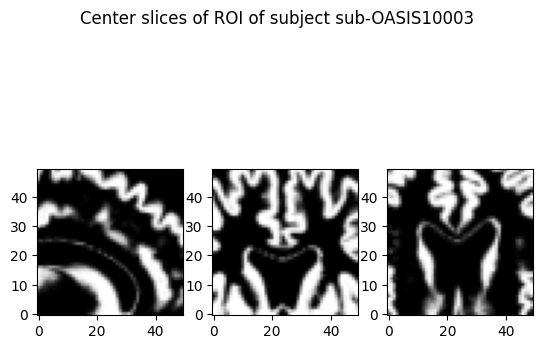

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import rotate

subject = 'sub-OASIS10003'
preprocessed_pt = torch.load(f'/content/drive/MyDrive/AD-DL/OASIS-1_dataset/CAPS/subjects/{subject}/ses-M00/' +
                    f'deeplearning_prepare_data/image_based/custom/{subject}_ses-M00_' +
                    'T1w_segm-graymatter_space-Ixi549Space_modulated-off_' +
                    'probability.pt')
raw_nii = nib.load(f'/content/drive/MyDrive/AD-DL/OASIS-1_dataset/raw/{subject}_ses-M00_T1w.nii.gz')

img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')

raw_np = raw_nii.get_fdata()

def show_slices(slices):
    """ Function to display a row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

slice_0 = raw_np[:, :, 78]
slice_1 = raw_np[122, :, :]
slice_2 = raw_np[:, 173, :]
show_slices([slice_0, rotate(slice_1, 90), rotate(slice_2, 90)])
plt.suptitle(f'Slices of raw image of subject {subject}')
plt.show()
print()

slice_0 = preprocessed_pt[0, 60, :, :]
slice_1 = preprocessed_pt[0, :, 72, :]
slice_2 = preprocessed_pt[0, :, :, 60]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle(f'Center slices of preprocessed image of subject {subject}')
plt.show()
print()

ROI_pt = MRIDatasetRoi(img_dir, OASIS_df)(preprocessed_pt)
slice_0 = ROI_pt[0, 15, :, :]
slice_1 = ROI_pt[0, :, 20, :]
slice_2 = ROI_pt[0, :, :, 15]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle(f'Center slices of ROI of subject {subject}')
plt.show()

In [ ]:
len(example_dataset)

377

In [ ]:
img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')
batch_size = 4

# transform = MinMaxNormalization인 경우
example_dataset = MRIDatasetRoi(img_dir, OASIS_df)
example_dataloader = DataLoader(example_dataset, batch_size=batch_size, drop_last=True)

for data in example_dataloader:
    pass

print(f"Shape of Dataset output:\n {example_dataset[0]['image'].shape}\n")

print(f"Shape of DataLoader output:\n {data['image'].shape}")

Shape of Dataset output:
 torch.Size([1, 121, 145, 121])

Shape of DataLoader output:
 torch.Size([4, 1, 121, 145, 121])


In [ ]:
img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')
batch_size = 4

example_dataset = MRIDatasetRoi(img_dir, OASIS_df, transform=ROI())
example_dataloader = DataLoader(example_dataset, batch_size=batch_size, drop_last=True)

for data in example_dataloader:
    pass

print(f"Shape of Dataset output:\n {example_dataset[0]['image'].shape}\n")

print(f"Shape of DataLoader output:\n {data['image'].shape}")

Shape of Dataset output:
 torch.Size([1, 50, 50, 50])

Shape of DataLoader output:
 torch.Size([4, 1, 50, 50, 50])


# Shape 

In [ ]:
conv_layer = nn.Conv3d(1, 8, 3)
print('Weights shape\n', conv_layer.weight.shape)
print()
print('Bias shape\n', conv_layer.bias.shape)

Weights shape
 torch.Size([8, 1, 3, 3, 3])

Bias shape
 torch.Size([8])


In [ ]:
batch_layer = nn.BatchNorm3d(16)
print('Gamma value\n', batch_layer.state_dict()['weight'].shape)
print()
print('Beta value\n', batch_layer.state_dict()['bias'].shape)

Gamma value
 torch.Size([16])

Beta value
 torch.Size([16])


In [ ]:
fc = nn.Linear(16, 2)
print("Weights shape \n", fc.weight.shape)
print()
print("Bias shape \n", fc.bias.shape)

Weights shape 
 torch.Size([2, 16])

Bias shape 
 torch.Size([2])


# Train

- CropMaxUnpool3d

In [ ]:
class PadMaxPool3d(nn.Module):
    """A MaxPooling module which deals with odd sizes with padding"""
    def __init__(self, kernel_size, stride, return_indices=False, return_pad=False):
        super(PadMaxPool3d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.pool = nn.MaxPool3d(kernel_size, stride, return_indices=return_indices)
        self.pad = nn.ConstantPad3d(padding=0, value=0)
        self.return_indices = return_indices
        self.return_pad = return_pad

    def set_new_return(self, return_indices=True, return_pad=True):
        self.return_indices = return_indices
        self.return_pad = return_pad
        self.pool.return_indices = return_indices

    def forward(self, f_maps):
        coords = [self.stride - f_maps.size(i + 2) % self.stride for i in range(3)]
        for i, coord in enumerate(coords):
            if coord == self.stride:
                coords[i] = 0

        self.pad.padding = (coords[2], 0, coords[1], 0, coords[0], 0)

        if self.return_indices:
            output, indices = self.pool(self.pad(f_maps))

            if self.return_pad:
                return output, indices, (coords[2], 0, coords[1], 0, coords[0], 0)
            else:
                return output, indices

        else:
            output = self.pool(self.pad(f_maps))

            if self.return_pad:
                return output, (coords[2], 0, coords[1], 0, coords[0], 0)
            else:
                return output

class CropMaxUnpool3d(nn.Module):
    def __init__(self, kernel_size, stride):
        super(CropMaxUnpool3d, self).__init__()
        self.unpool = nn.MaxUnpool3d(kernel_size, stride)

    def forward(self, f_maps, indices, padding=None):
        output = self.unpool(f_maps, indices)
        if padding is not None:
            x1 = padding[4]
            y1 = padding[2]
            z1 = padding[0]
            output = output[:, :, x1::, y1::, z1::]

        return output

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size

    def forward(self, input):
        return input.view(*self.size)

In [ ]:
class Conv4_FC3(nn.Module):
    def __init__(self, dropout=0, n_classes=2):
        super(Conv4_FC3, self).__init__()

        self.features = nn.Sequential(
            nn.Conv3d(1, 15, 3), # size 15@
            nn.BatchNorm3d(15),
            nn.ReLU(),
            PadMaxPool3d(2, 2),

            nn.Conv3d(15, 25, 3),
            nn.BatchNorm3d(25),
            nn.ReLU(),
            PadMaxPool3d(2, 2),

            nn.Conv3d(25, 50, 3),
            nn.BatchNorm3d(50),
            nn.ReLU(),
            PadMaxPool3d(2, 2),

            nn.Conv3d(50, 50, 3),
            nn.BatchNorm3d(50),
            nn.ReLU(),
            PadMaxPool3d(2, 2)

        )
        self.classifier = nn.Sequential(
            # Fully connected layers
            Flatten(),

            nn.Dropout(p=dropout),
            nn.Linear(50 * 2 * 2 * 2, 50),
            nn.ReLU(),

            nn.Dropout(p=dropout),
            nn.Linear(50, 40),
            nn.ReLU(),

            nn.Linear(40, n_classes)
        )

        self.flattened_shape = [-1, 50, 2, 2, 2]

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

In [ ]:
class AutoEncoder(nn.Module):

    def __init__(self, model=None):
        from copy import deepcopy
        super(AutoEncoder, self).__init__()

        self.level = 0

        if model is not None:
            self.encoder = deepcopy(model.features)
            self.decoder = self.construct_inv_layers(model)

            for i, layer in enumerate(self.encoder):
                if isinstance(layer, PadMaxPool3d):
                    self.encoder[i].set_new_return()
                elif isinstance(layer, nn.MaxPool3d):
                    self.encoder[i].return_indices = True
        else:
            self.encoder = nn.Sequential()
            self.decoder = nn.Sequential()

    def __len__(self):
        return len(self.encoder)

    def forward(self, x):

        indices_list = []
        pad_list = []
        for layer in self.encoder:
            if isinstance(layer, PadMaxPool3d):
                x, indices, pad = layer(x)
                indices_list.append(indices)
                pad_list.append(pad)
            elif isinstance(layer, nn.MaxPool3d):
                x, indices = layer(x)
                indices_list.append(indices)
            else:
                x = layer(x)
        code = x.view(x.size(0), -1)
        for layer in self.decoder:
            if isinstance(layer, CropMaxUnpool3d):
                x = layer(x, indices_list.pop(), pad_list.pop())
            elif isinstance(layer, nn.MaxUnpool3d):
                x = layer(x, indices_list.pop())
            else:
                x = layer(x)

        return code, x

    def construct_inv_layers(self, model):
        inv_layers = []
        for i, layer in enumerate(self.encoder):
            if isinstance(layer, nn.Conv3d):
                inv_layers.append(nn.ConvTranspose3d(layer.out_channels, layer.in_channels, layer.kernel_size,
                                                     stride=layer.stride, padding=layer.padding))
                self.level += 1
            elif isinstance(layer, PadMaxPool3d):
                inv_layers.append(CropMaxUnpool3d(layer.kernel_size, stride=layer.stride))
            elif isinstance(layer, nn.MaxPool3d):
                inv_layers.append(nn.MaxUnpool3d(layer.kernel_size, stride=layer.stride))
            elif isinstance(layer, nn.Linear):
                inv_layers.append(nn.Linear(layer.out_features, layer.in_features))
            elif isinstance(layer, Flatten):
                inv_layers.append(Reshape(model.flattened_shape))
            elif isinstance(layer, nn.LeakyReLU):
                inv_layers.append(nn.LeakyReLU(negative_slope=1 / layer.negative_slope))
            else:
                inv_layers.append(deepcopy(layer))
        inv_layers = self.replace_relu(inv_layers)
        inv_layers.reverse()
        return nn.Sequential(*inv_layers)

    @staticmethod
    def replace_relu(inv_layers):
        idx_relu, idx_conv = -1, -1
        for idx, layer in enumerate(inv_layers):
            if isinstance(layer, nn.ConvTranspose3d):
                idx_conv = idx
            elif isinstance(layer, nn.ReLU) or isinstance(layer, nn.LeakyReLU):
                idx_relu = idx

            if idx_conv != -1 and idx_relu != -1:
                inv_layers[idx_relu], inv_layers[idx_conv] = inv_layers[idx_conv], inv_layers[idx_relu]
                idx_conv, idx_relu = -1, -1

        # Check if number of features of batch normalization layers is still correct
        for idx, layer in enumerate(inv_layers):
            if isinstance(layer, nn.BatchNorm3d):
                conv = inv_layers[idx + 1]
                inv_layers[idx] = nn.BatchNorm3d(conv.out_channels)

        return inv_layers

In [ ]:
# Autoencoder train/test
def trainAE(model, train_loader, criterion, optimizer, n_epochs):
    best_model = deepcopy(model)
    train_best_loss = np.inf

    loss_valid = None

    for epoch in range(n_epochs):
        model.train()
        train_loader.dataset.train()
        for i, data in enumerate(train_loader, 0):
            # Retrieve mini-batch
            images, labels = data['image'].cuda(), data['label'].cuda()
            # Forward pass + loss computation
            _, outputs = model((images))
            loss = criterion(outputs, images)
            # Back-propagation
            loss.backward()
            del images, outputs
            # Parameters update
            optimizer.step()
            # Erase previous gradients
            optimizer.zero_grad()

        loss_train = testAE(model, train_loader, criterion)
        mean_loss_train = loss_train / (len(train_loader) * train_loader.batch_size)

        print(f'Epoch {epoch}: loss = {mean_loss_train:.6f}')

        if mean_loss_train < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = mean_loss_train

    return best_model

def testAE(model, data_loader, criterion):
    model.eval()
    data_loader.dataset.eval()
    total_loss = 0

    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data['image'].cuda(), data['label'].cuda()
            _, outputs = model((images))
            loss = criterion(outputs, images)
            total_loss += loss.item()

            del images, outputs, loss

    return total_loss

In [ ]:
img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')
transform = MinMaxNormalization()

train_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')

train_datasetROI = MRIDatasetRoi(img_dir, train_df, transform=transform) # torch.Size([1, 121, 145, 121])
train_loaderROI = DataLoader(train_datasetROI, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

learning_rate = 10**-4
n_epochs = 10
batch_size = 4

AEROI = AutoEncoder(Conv4_FC3()).cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(AEROI.parameters(), learning_rate)

best_AEROI = trainAE(AEROI, train_loaderROI, criterion, optimizer, n_epochs)

Epoch 0: loss = 0.038060
Epoch 1: loss = 0.029055
Epoch 2: loss = 0.019994
Epoch 3: loss = 0.015628
Epoch 4: loss = 0.013704
Epoch 5: loss = 0.011429
Epoch 6: loss = 0.010161
Epoch 7: loss = 0.007975
Epoch 8: loss = 0.007143
Epoch 9: loss = 0.006609


In [ ]:
# CNN train
def train(model, train_loader, criterion, optimizer, n_epochs):
    best_model = deepcopy(model)
    train_best_loss = np.inf

    for epoch in range(n_epochs):
        model.train()
        train_loader.dataset.train()
        for i, data in enumerate(train_loader, 0):
            # Retrieve mini-batch and put data on GPU with .cuda()
            images, labels = data['image'].cuda(), data['label'].cuda()
            # Forward pass
            # outputs = model(images)
            # Loss computation
            output, x = model(images)
            loss = criterion(output, labels)
            # loss = criterion(outputs, labels) # TypeError: cross_entropy_loss(): argument ‘input’ (position 1) must be Tensor, not tuple
            # Back-propagation (gradients computation)
            loss.backward()
            # Parameters update
            optimizer.step()
            # Erase previous gradients
            optimizer.zero_grad()

        _, train_metrics = test(model, train_loader, criterion)

        print(
            f"Epoch {epoch}: loss = {train_metrics['mean_loss']:.4f}, "
            f"accuracy = {train_metrics['balanced_accuracy']:.4f}"
            )

        if train_metrics['mean_loss'] < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = train_metrics['mean_loss']

    return best_model

def test(model, data_loader, criterion):
    model.eval()
    data_loader.dataset.eval()
    columns = ["participant_id", "proba0", "proba1",
               "true_label", "predicted_label"]
    results_df = pd.DataFrame(columns=columns)
    total_loss = 0

    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data['image'].cuda(), data['label'].cuda()
            # outputs = model(images)
            output, x = model(images)
            loss = criterion(output, labels)
            # loss = criterion(outputs, labels)
            total_loss += loss.item()
            probs = nn.Softmax(dim=1)(output)
            _, predicted = torch.max(output.data, 1)

            for idx, sub in enumerate(data['participant_id']):
                row = [sub,
                       probs[idx, 0].item(), probs[idx, 1].item(),
                       labels[idx].item(), predicted[idx].item()]
                row_df = pd.DataFrame([row], columns=columns)
                results_df = pd.concat([results_df, row_df])

    results_metrics = compute_metrics(results_df.true_label.values, results_df.predicted_label.values)
    results_df.reset_index(inplace=True, drop=True)
    results_metrics['mean_loss'] = total_loss / len(data_loader.dataset)

    return results_df, results_metrics


def compute_metrics(ground_truth, prediction):
    """Computes the accuracy, sensitivity, specificity and balanced accuracy"""
    tp = np.sum((prediction == 1) & (ground_truth == 1))
    tn = np.sum((prediction == 0) & (ground_truth == 0))
    fp = np.sum((prediction == 1) & (ground_truth == 0))
    fn = np.sum((prediction == 0) & (ground_truth == 1))

    metrics_dict = dict()
    metrics_dict['accuracy'] = (tp + tn) / (tp + tn + fp + fn)

    # Sensitivity
    if tp + fn != 0:
        metrics_dict['sensitivity'] = tp / (tp + fn)
    else:
        metrics_dict['sensitivity'] = 0.0

    # Specificity
    if fp + tn != 0:
        metrics_dict['specificity'] = tn / (fp + tn)
    else:
        metrics_dict['specificity'] = 0.0

    # metrics_dict['balanced_accuracy'] = (metrics_dict['sensitivity'] + metrics_dict['specificity']) / 2
    metrics_dict['balanced_accuracy'] = (tp + tn) / (tp + tn+ fp + fn)

    return metrics_dict

In [ ]:
img_dir = path.join('/content/drive/MyDrive/AD-DL/OASIS-1_dataset', 'CAPS')
transform = MinMaxNormalization()

train_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')
valid_df = pd.read_csv('/content/drive/MyDrive/AD-DL/OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')

train_datasetROI = MRIDatasetRoi(img_dir, train_df, transform=transform)
valid_datasetROI = MRIDatasetRoi(img_dir, valid_df, transform=transform)

learning_rate = 10**-4
n_epochs = 10
batch_size = 4

modelROI = best_AEROI.cuda() # best_AEROI 전이학습?

train_loaderROI = DataLoader(train_datasetROI, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loaderROI = DataLoader(valid_datasetROI, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelROI.parameters(), learning_rate)

best_modelROI = train(modelROI, train_loaderROI, criterion, optimizer, n_epochs)

valid_resultsROI_df, valid_metricsROI = test(best_modelROI, valid_loaderROI, criterion)
train_resultsROI_df, train_metricsROI = test(best_modelROI, train_loaderROI, criterion)
print()
print(valid_metricsROI)
print(train_metricsROI)

Epoch 0: loss = 0.9681, accuracy = 0.7527
Epoch 1: loss = 0.1377, accuracy = 0.8133
Epoch 2: loss = 0.1127, accuracy = 0.8100
Epoch 3: loss = 0.1080, accuracy = 0.8167
Epoch 4: loss = 0.0983, accuracy = 0.8267
Epoch 5: loss = 0.0933, accuracy = 0.8300
Epoch 6: loss = 0.0897, accuracy = 0.8433
Epoch 7: loss = 0.0799, accuracy = 0.8467
Epoch 8: loss = 0.0818, accuracy = 0.8567
Epoch 9: loss = 0.0762, accuracy = 0.8800

{'accuracy': 0.7894736842105263, 'sensitivity': 0.2857142857142857, 'specificity': 0.9032258064516129, 'balanced_accuracy': 0.7894736842105263, 'mean_loss': 0.020548747731493663}
{'accuracy': 0.88, 'sensitivity': 0.6379310344827587, 'specificity': 0.9380165289256198, 'balanced_accuracy': 0.88, 'mean_loss': 0.07618310663849115}


In [ ]:
valid_resultsROI_df = valid_resultsROI_df.merge(OASIS_df, how='left', on='participant_id', sort=False)
valid_resultsROI_old_df = valid_resultsROI_df[(valid_resultsROI_df.age_bl >= 62)]
compute_metrics(valid_resultsROI_old_df.true_label, valid_resultsROI_old_df.predicted_label)

{'accuracy': 0.5806451612903226,
 'sensitivity': 0.2857142857142857,
 'specificity': 0.8235294117647058,
 'balanced_accuracy': 0.5806451612903226}

In [ ]:
def show_slices(slices):
    """ Function to display a row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

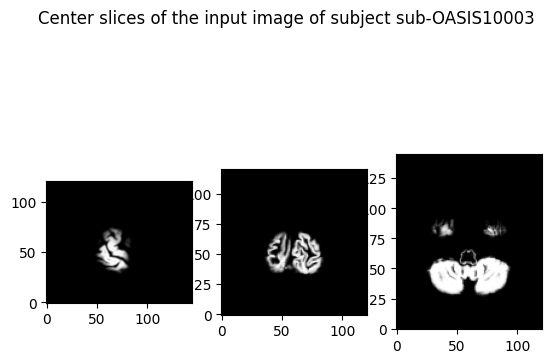

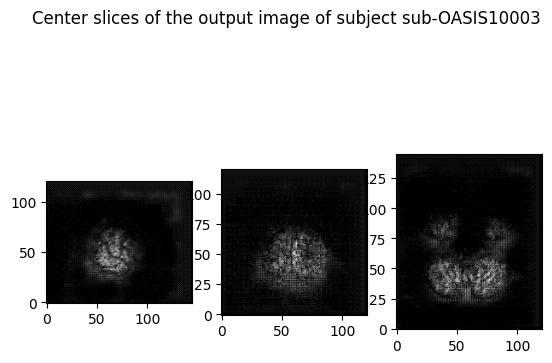

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import rotate

subject = 'sub-OASIS10003'
preprocessed_pt = torch.load(f'/content/drive/MyDrive/AD-DL/OASIS-1_dataset/CAPS/subjects/{subject}/ses-M00/' +
                    'deeplearning_prepare_data/image_based/custom/' + subject +
                    '_ses-M00_'+
                    'T1w_segm-graymatter_space-Ixi549Space_modulated-off_' +
                    'probability.pt')

input_pt = MinMaxNormalization()(preprocessed_pt).unsqueeze(0).cuda()
_, output_pt = best_AEROI(input_pt)


slice_0 = input_pt[0, 0, 15, :, :].cpu()
slice_1 = input_pt[0, 0, :, 20, :].cpu()
slice_2 = input_pt[0, 0, :, :, 15].cpu()
show_slices([slice_0, slice_1, slice_2])
plt.suptitle(f'Center slices of the input image of subject {subject}')
plt.show()
print()

slice_0 = output_pt[0, 0, 15, :, :].cpu().detach()
slice_1 = output_pt[0, 0, :, 20, :].cpu().detach()
slice_2 = output_pt[0, 0, :, :, 15].cpu().detach()
show_slices([slice_0, slice_1, slice_2])
plt.suptitle(f'Center slices of the output image of subject {subject}')
plt.show()